# Model Evaluation and Selection

* [Model Evaluation Selection](#one)
* [Confusion Matrices & Basic Evaluation Metrics](#two)
* [Classifier Decision Functions](#three)
* [Precission-recall and ROC Cureves](#four)
* [Multi-Class Evaluation](#five)
* [Regression Evaluation](#six)

## Import Modules

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.datasets import load_digits, load_diabetes
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

# Evaluation for Classification

In [2]:
dataset = load_digits()
X, y = dataset.data, dataset.target

In [3]:
dataset.target.shape

(1797,)

In [4]:
dataset.data.shape

(1797, 64)

In [5]:
dataset.data

array([[  0.,   0.,   5., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,  10.,   0.,   0.],
       [  0.,   0.,   0., ...,  16.,   9.,   0.],
       ..., 
       [  0.,   0.,   1., ...,   6.,   0.,   0.],
       [  0.,   0.,   2., ...,  12.,   0.,   0.],
       [  0.,   0.,  10., ...,  12.,   1.,   0.]])

In [6]:
np.unique(dataset.target)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
dataset.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
#Count number of occurrences of each value in array of non-negative ints
np.bincount(dataset.target)

array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180], dtype=int64)

The result of ``np.bincount`` are the number of occurances of the numbers in ``dataset.target_names``. 

In [9]:
for class_name, class_count in zip(dataset.target_names, np.bincount(dataset.target)):
    print(class_name, class_count)

0 178
1 182
2 177
3 183
4 181
5 182
6 181
7 179
8 174
9 180


However with this digits dataset, now what we're going to do is create a new dataset with two imbalanced classes. By labelling all digits that are not the digit 1 as the negative class with label 0, and digits that are 1 as the positive class, label 1. So what I've done here is dump the first few entries from the original labels along with the new binary label, so you can see the imbalance visually. 

In [10]:
# Creating a dataset with imbalanced binary classes:  
# Negative class (0) is 'not digit 1' 
# Positive class (1) is 'digit 1'
y_binary_imbalanced = y.copy()
y_binary_imbalanced[y_binary_imbalanced != 1] = 0

print('Original labels:\t', y[1:30])
print('New binary labels:\t', y_binary_imbalanced[1:30])

Original labels:	 [1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
New binary labels:	 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


Now when we use bincount, we can see that there are about 1,600 negative examples, but only 182 positive examples. So indeed, we have a dataset that is class imbalanced. Or as expected almost exactly a nine to one ratio of negative to positive examples. 

In [11]:
np.bincount(y_binary_imbalanced)    # Negative class (0) is the most frequent class

array([1615,  182], dtype=int64)

Now let's create a train test partition on this imbalance set. And then train a support vector machine classifier with these binary labels using the radial basis function as a kernel. We get the accuracy using the score method, and we can see this is just over 90%. Again at first glance, 90% accuracy for a classifier seems pretty good. 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary_imbalanced, random_state=0)

In [13]:
# Accuracy of Support Vector Machine classifier
svm = SVC(kernel='rbf', C=1).fit(X_train, y_train)
svm.score(X_test, y_test)

0.90888888888888886

In [16]:
accuracy_score(y_test, svm.predict(X_test))

0.90888888888888886

## Dummy Classifiers
(DummyClassifier is a classifier that makes predictions using simple rules, which can be useful as a baseline for comparison against actual classifiers, especially with imbalanced classes.)

However, now let's create a Dummy Classifier that correctly reflect the class imbalance to see if 90% really is that impressive. scikit-learn makes it easy to create a dummy classifier just by using the DummyClassifier class as shown here. 

Dummy classifiers, again, are called that because they don't even look at the data to make a prediction. They simply use the strategy or rule of thumb that you instruct them to use, when creating them. In fact, when you create the classifier, you set the strategy argument to tell it what rule of thumb to use to make its predictions. So here, we set this to the most frequent strategy to predict the most frequent class. 

The DummyClassifier here is used just like a regular classifier. So to prepare it for prediction, we call the fit method on the x_train and y_train variables that hold the training set instances and labels. Now this DummyClassifier won't actually be looking at the individual data instances of those variables. But it does use the y_train variable to determine which class in the training data is most frequent. 

Finally, just like a regular classifier, we can call the predict method to make predictions on the test set. This example shows the output of the DummyClassifier's predictions. And as promised, you can see it's always predicting 0 or the negative class for every instance in the test set. 

`sklearn.dummy.DummyClassifier(strategy=’stratified’, random_state=None, constant=None)`
DummyClassifier is a classifier that makes predictions using simple rules.
This classifier is useful as a simple baseline to compare with other (real) classifiers. Do not use it for real problems.

1. “stratified”: generates predictions by respecting the training set’s class distribution.
2. “most_frequent”: always predicts the most frequent label in the training set.
3. “prior”: always predicts the class that maximizes the class prior (like “most_frequent”) and predict_proba returns the class prior.
4. “uniform”: generates predictions uniformly at random.
5. “constant”: always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class

In [17]:
# Negative class (0) is most frequent
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
# Therefore the dummy 'most_frequent' classifier always predicts class 0
y_dummy_predictions = dummy_majority.predict(X_test)
y_dummy_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

Now we can call the usual score method to get the accuracy of the DummyClassifier's constant negative prediction. 
And we can see it's also 90%, the same as our earlier support vector machine classifier with radio bases function kernel. So that support vector classifier was actually performing only very slightly better than the DummyClassifier. 

In [18]:
dummy_majority.score(X_test, y_test)

0.9044444444444445

**The dummy classifier provides what is called a null accuracy baseline. That is the accuracy that can be achieved by always picking the most frequent class.** 

You should not use a dummy classifier for real classification problems, but it does provide a useful sanity check in point of comparison. There are other types of dummy classifiers that provide null base lines corresponding to other choices of the strategy parameter as shown here.

**most_frequent** is the strategy we've just seen that always predicts the most_frequent label. The **stratified** strategy, unlike the constant most_frequent prediction is a random prediction that's based on the class distributions. For example, if the positive class occurs 90% of the time in the training set. Then the stratified DummyClassifier will output the positive class label with 90% probability. Otherwise, it will output the negative class label. 

This can help ensure that metrics that rely on having counts of both positive and negative class prediction outcomes can be computed. The **uniform** strategy is another random prediction method that will generate class predictions uniformly at random. That is, all classes have an equal chance at being output as opposed to being weighed by their frequency in the training set. This strategy may be useful for gaining an accurate estimate of what the most common types of prediction errors for each class. 

Finally, the **constant** strategy can be useful when computing some metrics like F score, which we will cover in a few minutes. Well, why is that? Well, when we have a binary classification task where the most frequent class is the negative class. Turns out that using the most frequent strategy will never predict the positive class. And will never be able to count the number of positive instances that are correctly predicted. And so the overall count of such positive correct predictions will be 0. So this in turn as you will see in a few minutes, we'll cause some important metrics like F scores to always be zero. So using the constant strategy, we can force a dummy classifier to always predict the positive class even if it's the minority class in a set of classes. And this will lead to more meaningful computation of F-score. 


So what does it mean if we discover that our classifier has close to the DummyClassifier's performance? While typically it means that the features in our model may be ineffective, or erroneously computed or missing for some reason, it could also be caused by a poor choice of kernel or hyperparameter in the model. 

For example, if we change the support vector classifier's kernel parameter to linear from rbf. And recompute the accuracy on this retrain classifier, we can see that this leads to much better performance of almost 98% compared to the most frequently class based line of 90%.

In [19]:
svm = SVC(kernel='linear', C=1).fit(X_train, y_train)
svm.score(X_test, y_test)

0.97777777777777775

Finally, if you have accuracy that is close to that of a dummy classifier, it could be because there is indeed a large class imbalance. And the accuracy gains produced by the classifier on the test set simply applied too few examples to produce a significant gain. In general, for imbalanced classification problems, you should use metrics other than accuracy. We'll look at one shortly called AUC, which is short for area under the curve. 

DummyRegressors, as you might guess, are the counterpart to DummyClassifiers for regression. And they serve a similar role as a null outcome baseline and sanity check for regression models. Since regression models have continuous value prediction outputs. The strategy parameter for DummyRegressors gives you a choice of function that you can apply to the distribution of target values found in the training set. You can ask for the mean or median value of the training set targets. The value corresponding to the quantile that you provide or a custom constant value. 

## Confusion matrices

In [20]:
# Negative class (0) is most frequent
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
y_majority_predicted = dummy_majority.predict(X_test)
confusion1 = confusion_matrix(y_test, y_majority_predicted)

print('Most frequent class (dummy classifier)\n', confusion1)

Most frequent class (dummy classifier)
 [[407   0]
 [ 43   0]]


In [21]:
407/(407+43)

0.9044444444444445

In [22]:
dummy_majority.score(X_test, y_test)

0.9044444444444445

Here we apply the stratified DummyClassifier that gives random output in proportion to the ratio labels in the training set. Now the right column is no longer all zero because this DummyClassifier does predict occasionally  the positive class. If we add the numbers in the right column, we see that 44 plus 2 equals 46 times the number of times the classifier predicted the positive class. Of those times, in 2 cases, the lower right diagonal, this was a true positive. 

In [23]:
# produces random predictions w/ same class proportion as training set
dummy_classprop = DummyClassifier(strategy='stratified').fit(X_train, y_train)
y_classprop_predicted = dummy_classprop.predict(X_test)
confusion2 = confusion_matrix(y_test, y_classprop_predicted)

print('Random class-proportional prediction (dummy classifier)\n', confusion2)

Random class-proportional prediction (dummy classifier)
 [[364  43]
 [ 39   4]]


In [24]:
(370+3)/(370+3+40+37)

0.8288888888888889

In [25]:
dummy_classprop.score(X_test, y_test)

0.84444444444444444

In the next case, we'll apply a support vector classifier with linear kernel and seed parameter equal to one. 
We note that looking along the diagonal compared to the stratified dummy classifier above, which had a total of 363 plus 2, or 365 correct predictions. The support vector classifier has a total of 402 plus 38, which is 440 correct predictions on the same data set. 

In [26]:
svm = SVC(kernel='linear', C=1).fit(X_train, y_train)
svm_predicted = svm.predict(X_test)
confusion = confusion_matrix(y_test, svm_predicted)

print('Support vector machine classifier (linear kernel, C=1)\n', confusion)

Support vector machine classifier (linear kernel, C=1)
 [[402   5]
 [  5  38]]


In [27]:
(402+38)/(402+38+5+5)

0.9777777777777777

In [28]:
svm.score(X_test,y_test)

0.97777777777777775

Likewise, we can apply a logistic regression classifier, and that obtains similar results to the support vector classifier. 

In [29]:
lr = LogisticRegression().fit(X_train, y_train)
lr_predicted = lr.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted)

print('Logistic regression classifier (default settings)\n', confusion)

Logistic regression classifier (default settings)
 [[401   6]
 [  6  37]]


In [30]:
(401+37)/(401+37+6+6)

0.9733333333333334

In [31]:
lr.score(X_test,y_test)

0.97333333333333338

And finally, we can apply a decision tree classifier, and look at the confusion matrix that results from that. One thing we notice is, that unlike the support vector or logistic regression classifier, which had balanced numbers of false negatives and false positives. The decision tree makes more than twice as many false negative errors, 17 of them actually, as false positive errors, of which there are 7. Now that we've seen how a confusion matrix can give us a little more information about the types of errors a classifier makes, we're ready to move ahead and and define some new types of evaluation metrics that use information from the computing matrix to give different perspectives on classifier performance.

In [32]:
dt = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
tree_predicted = dt.predict(X_test)
confusion = confusion_matrix(y_test, tree_predicted)

print('Decision tree classifier (max_depth = 2)\n', confusion)

Decision tree classifier (max_depth = 2)
 [[400   7]
 [ 17  26]]


In [33]:
(400+26)/(400+26+17+7)

0.9466666666666667

In [34]:
dt.score(X_test,y_test)

0.94666666666666666

## accuracy_score, precision_score, recall_score, f1_score

[Link to definitions of statistical measures of the performance of a binary classification test, also known in statistics as classification function:](https://en.m.wikipedia.org/wiki/Sensitivity_and_specificity)

Let's take a look now at how we can compute these evaluation metrics in Python using scikit-learn. Scikit-learn metrics provides functions for computing accuracy, precision, recall, and F1 score as shown here in the notebook. The input to these functions is the same. The first argument here, **y_test, is the array of true labels of the test set data instances and the second argument is the array of predicted labels for the test set data instances**. Here we're using a variable called *tree_predicted* which are the predicted labels using the decision tree classifier in the previous notebook step. It's often useful when analyzing classifier performance to compute all of these metrics at once.

In [35]:
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, tree_predicted)))
print('Precision: {:.4f}'.format(precision_score(y_test, tree_predicted)))
print('Recall: {:.4f}'.format(recall_score(y_test, tree_predicted)))
print('F1: {:.4f}'.format(f1_score(y_test, tree_predicted)))

Accuracy: 0.9467
Precision: 0.7879
Recall: 0.6047
F1: 0.6842


So, sklearn metrics provides a handy **classification report function**. Like the previous core functions, classification report takes the true and predicted labels as the first two required arguments. It also takes some optional arguments that control the format of the output. Here, we use the target names option to label the classes in the output table. You can take a look at the [scikit-learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) for more information on the other output options. 

In [36]:
# Combined report with all above metrics
print(classification_report(y_test, tree_predicted, target_names=['not 1', '1']))

             precision    recall  f1-score   support

      not 1       0.96      0.98      0.97       407
          1       0.79      0.60      0.68        43

avg / total       0.94      0.95      0.94       450



Here we show classification reports for four different classifiers on the binary digit classification problem. The first set of results is from the dummy classifier and we can see that as expected both precision and recall for the positive class are very low since the dummy classifier is simply guessing randomly with low probability of predicting that positive class for the positive instances. 

In [37]:
print('Random class-proportional (dummy)\n', 
      classification_report(y_test, y_classprop_predicted, target_names=['not 1', '1']))
print('SVM\n', 
      classification_report(y_test, svm_predicted, target_names = ['not 1', '1']))
print('Logistic regression\n', 
      classification_report(y_test, lr_predicted, target_names = ['not 1', '1']))
print('Decision tree\n', 
      classification_report(y_test, tree_predicted, target_names = ['not 1', '1']))

Random class-proportional (dummy)
              precision    recall  f1-score   support

      not 1       0.90      0.89      0.90       407
          1       0.09      0.09      0.09        43

avg / total       0.83      0.82      0.82       450

SVM
              precision    recall  f1-score   support

      not 1       0.99      0.99      0.99       407
          1       0.88      0.88      0.88        43

avg / total       0.98      0.98      0.98       450

Logistic regression
              precision    recall  f1-score   support

      not 1       0.99      0.99      0.99       407
          1       0.86      0.86      0.86        43

avg / total       0.97      0.97      0.97       450

Decision tree
              precision    recall  f1-score   support

      not 1       0.96      0.98      0.97       407
          1       0.79      0.60      0.68        43

avg / total       0.94      0.95      0.94       450



## Decision functions

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary_imbalanced, random_state=0)
y_scores_lr = lr.fit(X_train, y_train).decision_function(X_test)
y_score_list = list(zip(y_test[0:20], y_scores_lr[0:20]))

# show the decision_function scores for first 20 instances
y_score_list

[(0, -23.176547400757663),
 (0, -13.541223742469006),
 (0, -21.722500473360618),
 (0, -18.907578437722535),
 (0, -19.736034587372778),
 (0, -9.7493459511792651),
 (1, 5.2349002124953099),
 (0, -19.30716117885968),
 (0, -25.101015601857377),
 (0, -21.827250934235906),
 (0, -24.150855663826746),
 (0, -19.576844844946265),
 (0, -22.574902551102674),
 (0, -10.823739601445064),
 (0, -11.912425566043064),
 (0, -10.97956652705531),
 (1, 11.205846086251944),
 (0, -27.645770221552823),
 (0, -12.859636015637092),
 (0, -25.848590145556187)]

Likewise, the **predict proba function provides predicted probabilities of class membership**. Typically a classifier which use the more likely class. That is in a binary classifier, you find the class with probability greater than 50%. Adjusting this decision threshold affects the prediction of the classifier. 

**A higher threshold means that a classifier has to be more confident in predicting the class**. For example, we might predict class one only if the estimated probability of class one was over 70%. And this results in a more conservative classifier. 

Here's an example of getting these prediction probabilities for the test instances for the same logistic regression classifier. You can see that many entries with a positive label of one, have a high probability like 0.995. While many negative label instances have a very low prediction probability. Note that not all models provide useful probability estimates of this type. For example, a model that was over-fit to a trending set. Might provide overly optimistic high probabilities that were in fact not accurate. 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary_imbalanced, random_state=0)
y_proba_lr = lr.fit(X_train, y_train).predict_proba(X_test)
y_proba_list = list(zip(y_test[0:20], y_proba_lr[0:20,1]))

# show the probability of positive class for first 20 instances
y_proba_list

[(0, 8.6010872706740499e-11),
 (0, 1.3155903495453823e-06),
 (0, 3.6816111034009875e-10),
 (0, 6.1452989618944584e-09),
 (0, 2.6837934145133791e-09),
 (0, 5.8329401240781557e-05),
 (1, 0.99470087426871634),
 (0, 4.1210362715903745e-09),
 (0, 1.2553575357627774e-11),
 (0, 3.3154719959007555e-10),
 (0, 3.2465093048358345e-11),
 (0, 3.1469099051059103e-09),
 (0, 1.5698002448420801e-10),
 (0, 1.9920533537070619e-05),
 (0, 6.706507243234968e-06),
 (0, 1.7046194538057202e-05),
 (1, 0.99998640569605668),
 (0, 9.8535912965519826e-13),
 (0, 2.6009374594983658e-06),
 (0, 5.9442892596185542e-12)]

## Precision-recall curves

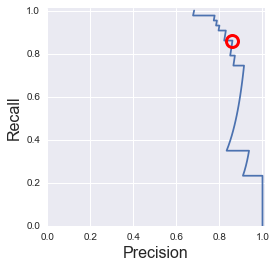

In [40]:
# Precission Vs Recall curve Logistic regression
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure(figsize=(7,4))
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

## ROC curves, Area-Under-Curve (AUC)

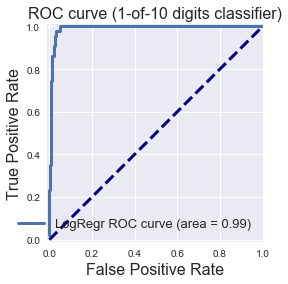

In [41]:
# Roc for binary imbalance classificator lorgistic regression
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
## sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)[source]
## Returns: fpr = Increasing false positive rates; trp = Increasing true positive rates; 
#thresholds: Decreasing thresholds on the decision function used to compute fpr and tpr.
X_train, X_test, y_train, y_test = train_test_split(X, y_binary_imbalanced, random_state=0)

y_score_lr = lr.fit(X_train, y_train).decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(7,4))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

gamma = 0.01  accuracy = 0.91   AUC = 1.00
gamma = 0.10  accuracy = 0.90   AUC = 0.98
gamma = 0.20  accuracy = 0.90   AUC = 0.66
gamma = 1.00  accuracy = 0.90   AUC = 0.50


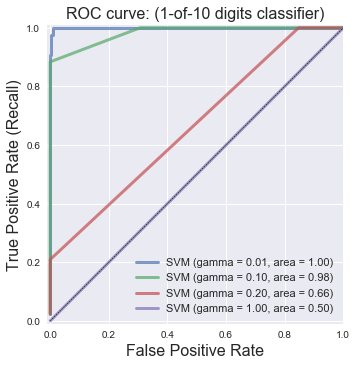

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary_imbalanced, random_state=0)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
for g in [0.01, 0.1, 0.20, 1]:
    svm = SVC(gamma=g).fit(X_train, y_train)
    y_score_svm = svm.decision_function(X_test)
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    accuracy_svm = svm.score(X_test, y_test)
    print("gamma = {:.2f}  accuracy = {:.2f}   AUC = {:.2f}".format(g, accuracy_svm, 
                                                                    roc_auc_svm))
    plt.plot(fpr_svm, tpr_svm, lw=3, alpha=0.7, 
             label='SVM (gamma = {:0.2f}, area = {:0.2f})'.format(g, roc_auc_svm))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.plot([0, 1], [0, 1], color='k', lw=0.5, linestyle='--')
plt.legend(loc="lower right", fontsize=11)
plt.title('ROC curve: (1-of-10 digits classifier)', fontsize=16)
plt.axes().set_aspect('equal')

plt.show()

## Multi-class confusion matrix

In this example which was created using the following notebook code based on a support vector classifier with linear kernel, we can see that most of the predictions are correct with only a few misclassifications here and there. The most frequent type of mistake here is apparently misclassifying the true digit, eight as a predicted digit one which happened three times. 

And indeed, the overall accuracy is high, about 97% as shown here. As an aside, it's sometimes useful to display a confusion matrix as a heat map in order to highlight the relative frequencies of different types of errors. So, I've included the code to generate that here. For comparison, I've also included a second confusion matrix on the same dataset for another support vector classifier that does much worse in a distinctive way. The only change is to use an RBF, radial basis function kernel instead of a linear kernel. While we can see for the accuracy number were about 43% below the confusion matrix that the classifier is doing much worse than the linear kernel, that single number doesn't give much insight into why. 

Looking at the confusion matrix, however, reveals that for every true digit class, a significant fraction of outcomes are to predict the digit four. That's rather surprising. For example, of the 44 instances of the true digit 2 in row 2, 17 are classified correctly, but 27 are classified as the digit 4. Clearly, something is broken with this model and I picked this second example just to show an extreme example of what you might see when things go quite wrong. This digits dataset is well-established and free of problems. But especially when developing with a new dataset, seeing patterns like this in a confusion matrix could give you valuable clues about possible problems, say in the feature pre-processing for example. **So as a general rule of thumb as part of model evaluation, I suggest always looking at the confusion matrix for your classifier. To get some insight into what kind of errors it is making for each class including whether some classes are much more prone to certain kinds of errors than others**. 

In [44]:
dataset = load_digits()
X, y = dataset.data, dataset.target
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(X, y, random_state=0)

svm = SVC(kernel = 'linear').fit(X_train_mc, y_train_mc)
svm_predicted_mc = svm.predict(X_test_mc)
confusion_mc = confusion_matrix(y_test_mc, svm_predicted_mc)
confusion_mc

array([[37,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 42,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0, 44,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 43,  0,  0,  0,  0,  1,  1],
       [ 0,  0,  0,  0, 38,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 47,  0,  0,  0,  1],
       [ 0,  1,  0,  0,  0,  0, 51,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 47,  0,  0],
       [ 0,  3,  1,  0,  0,  0,  0,  0, 44,  0],
       [ 0,  0,  0,  1,  0,  1,  0,  0,  1, 44]], dtype=int64)

In [45]:
df_cm = pd.DataFrame(confusion_mc, 
                     index = [i for i in range(0,10)], columns = [i for i in range(0,10)])

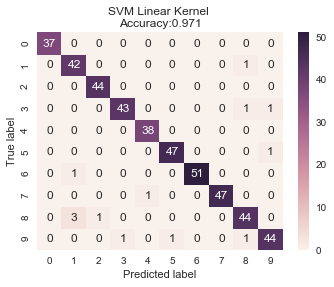

In [48]:
plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm, annot=True)
plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'
          .format(accuracy_score(y_test_mc,svm_predicted_mc)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [49]:
svm = SVC(kernel = 'rbf').fit(X_train_mc, y_train_mc)
svm_predicted_mc = svm.predict(X_test_mc)
confusion_mc = confusion_matrix(y_test_mc, svm_predicted_mc)
df_cm = pd.DataFrame(confusion_mc, index = [i for i in range(0,10)],
                  columns = [i for i in range(0,10)])

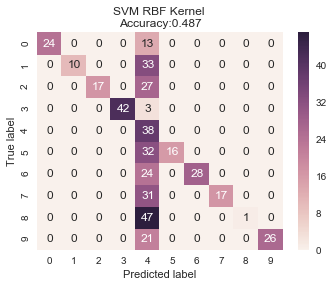

In [50]:
plt.figure(figsize = (5.5,4))
sns.heatmap(df_cm, annot=True)
plt.title('SVM RBF Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test_mc, 
                                                                    svm_predicted_mc)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Multi-class classification report

Next, just as in the binary case, you can get a classification report that summarizes multiple evaluation metrics for a multi-class classifier with an average metric computed for each class. 

In [51]:
print(classification_report(y_test_mc, svm_predicted_mc))

             precision    recall  f1-score   support

          0       1.00      0.65      0.79        37
          1       1.00      0.23      0.38        43
          2       1.00      0.39      0.56        44
          3       1.00      0.93      0.97        45
          4       0.14      1.00      0.25        38
          5       1.00      0.33      0.50        48
          6       1.00      0.54      0.70        52
          7       1.00      0.35      0.52        48
          8       1.00      0.02      0.04        48
          9       1.00      0.55      0.71        47

avg / total       0.93      0.49      0.54       450



## Micro- vs. macro-averaged metrics

Here, we use the average parameter on the scoring function. In the first example, we used the precision metric and specify whether we want micro-average precision which is the first case or macro-average precision in the second case. 

In [52]:
print('Micro-averaged precision = {:.2f} (treat instances equally)'
      .format(precision_score(y_test_mc, svm_predicted_mc, average = 'micro')))
print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(precision_score(y_test_mc, svm_predicted_mc, average = 'macro')))

Micro-averaged precision = 0.49 (treat instances equally)
Macro-averaged precision = 0.91 (treat classes equally)


In the second example, we use the f1 metric and compute micro and macro-averaged f1. 
Now that we've seen how to compute these metrics, let's take a look at how to use them to do model selection. 

In [53]:
print('Micro-averaged f1 = {:.2f} (treat instances equally)'
      .format(f1_score(y_test_mc, svm_predicted_mc, average = 'micro')))
print('Macro-averaged f1 = {:.2f} (treat classes equally)'
      .format(f1_score(y_test_mc, svm_predicted_mc, average = 'macro')))

Micro-averaged f1 = 0.49 (treat instances equally)
Macro-averaged f1 = 0.54 (treat classes equally)


# Regression evaluation metrics

You can look at the notebook to see that a dummy regressor is created and used just like a regular regression model. You create, fit with the training data, and then call predict on the test data. Although again, like the dummy classifier you should not use the dummy regressor for actual problems. Its only use is to provide a baseline for comparison. 

Looking at the regression metrics output from the linear model compared to the dummy model. We can see that as expected the dummy regressor achieves an r squared score of 0. Since it always makes a constant prediction without looking at the output. In this instance the linear model provides only slightly better fit than the dummy regressor, according to both mean squared error and the r2_score. 

Linear model, coefficients:  [-698.80206267]
Mean squared error (dummy): 4965.13
Mean squared error (linear model): 4646.74
r2_score (dummy): -0.00
r2_score (linear model): 0.06


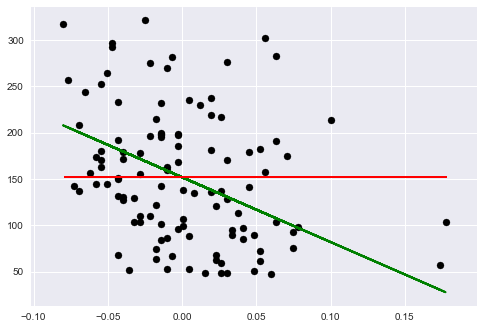

In [55]:
diabetes = load_diabetes()
#this is the sames as: diabetes.data[:, 6:7]
X = diabetes.data[:, None, 6]
y = diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

lm = LinearRegression().fit(X_train, y_train)
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
y_predict = lm.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)

print('Linear model, coefficients: ', lm.coef_)
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_mean)))
print("Mean squared error (linear model): {:.2f}".format(mean_squared_error(y_test, y_predict)))
print("r2_score (dummy): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (linear model): {:.2f}".format(r2_score(y_test, y_predict)))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_predict, color='green', linewidth=2)
plt.plot(X_test, y_predict_dummy_mean, color='red', linestyle = 'dashed', 
         linewidth=2, label = 'dummy')

plt.show()

# Model selection using evaluation metrics

Know that you've seen a number of different evaluation metrics for both binary and multiclass classification, let's take a look at how you can apply them as criteria for selecting the best classifier for your application, otherwise known as model selection. In previous lectures, we've seen a number of different evaluation frameworks for potential model selection. 

* First, we simply did training and testing on the same dataset which as we well know typically over fits badly and doesn't generalize well to new data. As a side note however, it can serve as a useful sanity check to make sure your software engineering and feature generation pipeline is working correctly. 

* Second, we frequently use the single train test split to produce a single evaluation metric. While fast and easy, this doesn't give as realistic a set of estimates for how well the model may work on future new data and we don't get a good picture for the variance in the evaluation metrics that may result as we do prediction on different test sets.

* Third, we used Kfold cross-validation to create K random train test splits, where the evaluation metric was average across splits. This leads to models that are more reliable and unseen data. In particular, we can also use **grid search** using for example the grid search CV method with **within each cross-validation fold to find optimal parameters for a model with respect to the evaluation metric**. The default evaluation metric used for cross value score or grid search CV is accuracy. So, how do you apply the new metrics you've learned about here like AUC in model selection? Sklearn makes this very easy. You simply add a scoring parameter that set the string with the name of the evaluation metric you want to use.

## Cross-validation example

Let's first look an example using the **scoring parameter for cross-validation** and then we'll take a look at the other primary method of model selection **grid search**. In the notebook here, we have a cross-validation example where we're running five folds using a support vector classifier (SVC) with the linear kernel and C parameter set to 1. 

The first call to cross validations score just uses default accuracy as the evaluation metric. The second call, uses the scoring parameter using the string Orosi underscore AUC. And this will use AUC as the evaluation metric. The third call, sets the scoring parameter to recall to use that as the evaluation metric. You can see the resulting list of five evaluation values one per fold for each metric. Now you are not doing any parameter tuning, we're simply evaluating our models average performance across multiple folds. 

In [56]:
dataset = load_digits()
# again, making this a binary problem with 'digit 1' as positive class 
# and 'not 1' as negative class
X, y = dataset.data, dataset.target == 1
clf = SVC(kernel='linear', C=1)
# accuracy is the default scoring metric
print('Cross-validation (accuracy)', cross_val_score(clf, X, y, cv=5))
# use AUC as scoring metric
print('Cross-validation (AUC)', cross_val_score(clf, X, y, cv=5, scoring = 'roc_auc'))
# use recall as scoring metric
print('Cross-validation (recall)', cross_val_score(clf, X, y, cv=5, scoring = 'recall'))

Cross-validation (accuracy) [ 0.91944444  0.98611111  0.97214485  0.97493036  0.96935933]
Cross-validation (AUC) [ 0.9641871   0.9976571   0.99372205  0.99699002  0.98675611]
Cross-validation (recall) [ 0.81081081  0.89189189  0.83333333  0.83333333  0.83333333]


## Grid search example

Now in this grid search example, we use a support vector classifier that uses a radio basis function kernel(RBF). When the critical parameter here is the **gamma parameter that intuitively sets the radius or width of influence of the kernel**. We use a [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to **find the value of gamma that optimizes the given evaluation metric** in two cases: In the first case, we just optimize for average accuracy. In the second case, we optimize for AUC. 

In this particular case, the optimal value of gamma happens to be the same point 0.01 for both evaluation metric but as we'll see later in other cases the optimal parameter value can be quite different depending on the evaluation metric used to optimize.

In [58]:
dataset = load_digits()
X, y = dataset.data, dataset.target == 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = SVC(kernel='rbf')
grid_values = {'gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values)
grid_clf_acc.fit(X_train, y_train)
y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

# alternative metric to optimize over grid parameters: AUC
grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train, y_train)
y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test) 

print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)

Grid best parameter (max. accuracy):  {'gamma': 0.001}
Grid best score (accuracy):  0.996288047513
Test set AUC:  0.999828581224
Grid best parameter (max. AUC):  {'gamma': 0.001}
Grid best score (AUC):  0.99987412783


## Evaluation metrics supported for model selection
You can see the complete list of names for the evaluation metric supported by the scoring parameter by running the following code that uses the score's variable imported from sklearn metrics. You can see metrics for classification such as the string ``precision_micro`` that represents micro or average precision as well as metrics for regression such as the R2 metric for R-squared regression loss. 

In [59]:
from sklearn.metrics.scorer import SCORERS
print(sorted(list(SCORERS.keys())))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'log_loss', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']


# Two-feature classification example using the digits dataset

Let's take a look at a specific example that shows how a classifiers decision boundary changes when it's optimized for different evaluation metrics. This classification problem is based on the same binary digit classifier training and test sets we've been using as an example throughout the notebook. In this classification visualization examples the **positive examples the digit 1** are shown as **black points** and the **region of positive class prediction is shown in the light colored or yellow region to the right of the decision boundary**. The **negative examples**, all other digits **are shown as white points and the region of negative classed prediction** here and these figures **is to the left of the decision boundary**. The data points have been plotted using two out of the 64 feature values in the digits dataset and have been jittered a little. That is, about a little bit of random noise so we can see more easily the density of examples in the feature space. 

Here's the sklearn code that produced this figure. We apply grid search here to explore different values of the optional class weight parameter that controls how much weight is given to each of the two classes during training. As it turns out, optimizing for different evaluation metrics results in different optimal values of the class weight parameter. As a class weight parameter increases more emphasis will be given to correctly classifying the positive class instances. The **precision oriented classifier** we see here with class weight of two **tries hard to reduce false positive while increasing true positives**. So it focuses on the cluster of positive class points in the lower right corner where there are relatively few negative class points. Here, precision is over 50 percent. In contrast, the **recall oriented classifier** with class way to 50, **tries hard to reduce the number of false negatives while increasing true positives**. That is, it tries to find most of the positive class points as part of its positive class predictions. 

We can also see that the decision boundary for the F1 oriented classifier has an optimal class weight of two which is between the optimal class weight values for the precision and recall oriented classifiers. Visually, we can see that the F1 oriented classifier also has a kind of intermediate positioning between the precision and recall oriented decision boundaries. This makes sense given that F1 is the harmonic mean of precision and recall. The AUC oriented classifier with optimal class weight of 5, has a similar decision boundary to the F1 oriented classifier but shifted slightly in favor of higher recall. 

## Optimizing a classifier using different evaluation metrics

In [61]:
dataset = load_digits()
X, y = dataset.data, dataset.target == 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create a two-feature input vector matching the example plot above
# We jitter the points (add a small amount of random noise) in case there are areas
# in feature space where many instances have the same features.
jitter_delta = 0.25
X_twovar_train = X_train[:,[20,59]] + np.random.rand(X_train.shape[0], 2) - jitter_delta
X_twovar_test  = X_test[:,[20,59]] + np.random.rand(X_test.shape[0], 2) - jitter_delta

clf = SVC(kernel = 'linear').fit(X_twovar_train, y_train)
grid_values = {'class_weight':['balanced', {1:2},{1:3},{1:4},{1:5},{1:10},{1:20},{1:50}]}

for i, eval_metric in enumerate(('precision','recall', 'f1','roc_auc')):
    grid_clf_custom = GridSearchCV(clf, param_grid=grid_values, scoring=eval_metric)
    grid_clf_custom.fit(X_twovar_train, y_train)
    print('Grid best parameter (max. {0}): {1}'
          .format(eval_metric, grid_clf_custom.best_params_))
    print('Grid best score ({0}): {1}'
          .format(eval_metric, grid_clf_custom.best_score_))

Grid best parameter (max. precision): {'class_weight': {1: 2}}
Grid best score (precision): 0.5403571723170832
Grid best parameter (max. recall): {'class_weight': {1: 50}}
Grid best score (recall): 0.9284310837047003
Grid best parameter (max. f1): {'class_weight': {1: 4}}
Grid best score (f1): 0.495364873345092
Grid best parameter (max. roc_auc): {'class_weight': {1: 20}}
Grid best score (roc_auc): 0.8882247480310446


## Precision-recall curve for the default SVC classifier (with balanced class weights)

We can see the precision recall tradeoff very clearly for this classification scenario in the precision recall curve for the default for vector classifier with linear kernel optimized for accuracy on the same dataset and using the balanced option for the class parameter. Let's take a look at the code that generated this plot.

Take a moment to imagine how the extreme lower right part of the curve on this precision recall curve represents a decision boundary that's highly precision oriented. In the lower right of the classification plot where there's a cluster of positive examples. As the decision threshold is shifted to become less and less conservative, tracing the curve up into the left, the classifier becomes more and more like the recall oriented support vector classifier example. **Again, the red circle represents the precision recall tradeoff achieved at the zero score mark, which is the actual decision boundary chosen for the trained classifier**. 

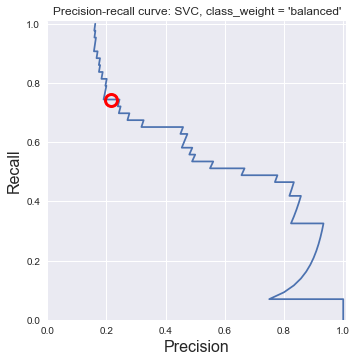

At zero threshold, precision: 0.22, recall: 0.74


In [62]:
dataset = load_digits()
X, y = dataset.data, dataset.target == 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# create a two-feature input vector matching the example plot above
jitter_delta = 0.25
X_twovar_train = X_train[:,[20,59]]+ np.random.rand(X_train.shape[0], 2) - jitter_delta
X_twovar_test  = X_test[:,[20,59]] + np.random.rand(X_test.shape[0], 2) - jitter_delta

clf = SVC(kernel='linear', class_weight='balanced').fit(X_twovar_train, y_train)
y_scores = clf.decision_function(X_twovar_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.title ("Precision-recall curve: SVC, class_weight = 'balanced'")
plt.plot(precision, recall, label = 'Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize=12, fillstyle='none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()
print('At zero threshold, precision: {:.2f}, recall: {:.2f}'
      .format(closest_zero_p, closest_zero_r))

For simplicity, we've often used a single train test split in showing examples of evaluation scoring. However using only cross-validation or a test set for model selection or parameter tuning may still lead to more settle forms of overfitting and less optimistic evaluation estimates for future unseen data. 

An intuitive explanation for this might be the following. Remember that the whole point of evaluating our test set is to estimate how well a learning algorithm might perform on future unseen data. **The more information we see about our dataset as part of repeated cross-validation passes in choosing our model, the more influence any potential held up test data has played into selecting the final model not merely evaluating it. This is sometimes called data leakage** and we'll describe more about that phenomenon in another module. 

So, we haven't done an evaluation with truly held out test set and let's we commit to holding back a test split that isn't seen by any process until the very end of the evaluation. So that's what's actually done in practice. There are three data splits:
* Training for model building
* Validation for model selection
* A test set for the final evaluation. 

**The training and test sets are typically split out first and then cross-validation is run using the training data to do model and parameter selection. Again, the test set is not seen until the very end of the evaluation process**. Machine learning researchers take this protocol very seriously. They train, validate, test design is a very important universally applied framework for effective evaluation of machine learning models. 

That brings us to the end of this section of the course of evaluation for machine learning.** You should now understand why accuracy only gives a partial picture of a classifier's performance and be more familiar with the motivation and definition of important alternative evaluation methods and metrics of machine learning like confusion matrices, precision recall, F 1 score and area under the RC curve**. You've also seen how to apply and choose these different evaluation metric alternatives in order to optimize model selection or parameter tuning for a classifier to maximize a given evaluation metric. 

Finally, I'd like to leave you with a couple of points:

* First, simple accuracy may not often be the right goal for your particular machine learning application. As we saw for example with tumor detection or credit card fraud, false positives and false negatives might have very different real world effects for users or for organization outcomes. **So, it's important to select an evaluation metric that reflects those user application or business needs**. 
* Second, there are a number of other dimensions along which it may be important to evaluate your machine learning algorithms that we don't cover here but that are important for you to be aware of. I'll mention two specifically here. **Learning curves are used to assess how a machine learning algorithms evaluation metric changes or improves as the algorithm gets more training data. Learning curve may be useful as part of a cost benefit analysis**. Gathering training data in the form of labeled examples is often time consuming and expensive. So being able to estimate the likely performance improvement of your classifier if you say invest in doubling the amount of training data can be a useful analysis. *Sensitivity analysis*, amounts in looking at how an evaluation metric changes and small adjustments are made to important model parameters. This helps assess how robust the model is to choice of parameters. This may be important to perform especially if there are other costs such as runtime efficiency that are critical variables when deploying an operational system that are correlated with different values of parameter, for example, decision tree depth or future value threshold. In this way, a more complete picture of the tradeoffs achievable across different performance dimensions can help you make the best practical deployment decisions for your machine learning model. 